# Setup

**We need python verison < 3.10 for jenga**

In [ ]:
# Install dependencies (using python 3.8)
from IPython.display import clear_output
!pip3.8 install pandas jenga
clear_output()

In [ ]:
# Ensure correct python version
import sys
print(sys.version)
assert sys.version_info >= (3, 7, 0)
assert sys.version_info < (3, 10, 0)

3.8.0 (tags/v3.8.0:fa919fd, Oct 14 2019, 19:37:50) [MSC v.1916 64 bit (AMD64)]


In [ ]:
import json
import pandas as pd
import jenga
import numpy as np
import os

In [ ]:
# download & unzip second (renttherunway) dataset if needed
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/renttherunway/renttherunway_final_data.json.gz
!gzip -d renttherunway_final_data.json.gz -f

--2024-03-20 17:54:59--  https://datarepo.eng.ucsd.edu/mcauley_group/data/renttherunway/renttherunway_final_data.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31493535 (30M) [application/x-gzip]
Saving to: ‘renttherunway_final_data.json.gz’

renttherunway_final 100%[===================>]  30,03M   720KB/s    in 57s     

2024-03-20 17:55:57 (537 KB/s) - ‘renttherunway_final_data.json.gz’ saved [31493535/31493535]



# Injecting Errors with Jenga

## Missing Values

'Missingness' Terminology:
*   **MCAR:** Missing completely at random
*   **MAR:** Missing at random - corruption is conditioned on other column
*   **MNAR:** Missing not at random - corruption is conditioned on values in column on which it is applied

In [ ]:
#USABLE
from jenga.corruptions.generic import MissingValues

def missing_values(df, column, fraction=.5, missingness='MCAR'):

    df[column] = MissingValues(column=column, fraction=fraction, missingness=missingness).transform(df)[column]
    return df


In [ ]:
from jenga.basis import DataCorruption
class MillisInsteadOfSeconds ( DataCorruption ):

    def transform ( self , data, column ):
        self.fraction = 0.2
        self.column = column
        # Operate on a copy of the data
        corrupted_data = data.copy( deep = True )
        # Pick a random fraction of the rows
        # Multiply the column values of the chosen rows
        corrupted_data[self.column] = corrupted_data[self.column] * 1000
        return corrupted_data

def second_to_millis(df, column):
  tranfomer = MillisInsteadOfSeconds()
  df = df.ffill()
  df = tranfomer.transform(df, column)
  return df

## Swapping Values

In [ ]:
#USABLE
from jenga.corruptions.generic import SwappedValues

def swapping_values(df, column1, column2, fraction=.5, missingness='MCAR'):
  print(df.columns)
  print(column1, column2)
  df = SwappedValues(column=column1, fraction=fraction, sampling=missingness, swap_with=column2).transform(df)
  return df


## Messing up categorical values

In [ ]:
#USABLE
from jenga.corruptions.generic import CategoricalShift

def permute_categories(df, column, fraction=.5, missingness='MAR'):
    df[column] = CategoricalShift(column=column, fraction=fraction, sampling=missingness).transform(df)[column]
    return df

## Adding Gaussian Noise and rounding

In [ ]:
from jenga.corruptions.numerical import GaussianNoise

def noise_and_rounding(df, column, fraction=.5, missingness='MCAR'):
  df[column] = df[column].astype(str)
  parts = df[column].str.extract(r'^(\D*?)(\d+\.*\d*)(.*)')
  parts[1] = parts[1].astype(float)
  df[column] = GaussianNoise(column=column, fraction=fraction, sampling=missingness).transform(df)[column]


  df[column] = df[column].round(0).astype(int)

  combined_values = parts[0] + parts[1].astype(str) + parts[2]

  df[column] = combined_values

  return df



## Scaling error


In [ ]:
#USABLE
from jenga.corruptions.numerical import Scaling

def scale(df, column, fraction=.5, missingness='MCAR'):

  df[column] = df[column].astype(str)

  parts = df[column].str.extract(r'^(\D*?)(\d+\.*\d*)(.*)')


  parts[1] = parts[1].astype(float)

  parts[1] = Scaling(column = 1, fraction =fraction, sampling=missingness).transform(parts)[1]

  # Append non-numerical part to numerical part
  combined_values = parts[0] + parts[1].astype(str) + parts[2]

  df[column] = combined_values



  return df


## Unit Conversion

In [ ]:
from jenga.basis import TabularCorruption

# transforms string data for height in feet and inches into corresponding height in meters and cm
class UnitTransform(TabularCorruption):
    #Imperial to metric
    def convert_to_metric(self, height):
      if 'ft' in height and 'in' in height:
        feet, inches = height.split(' ')
        feet_cm = float(feet.replace("'","")) * 30.48
        inches_cm = float(inches.replace('"',"")) * 2.54
        height_in_cm = round(feet_cm + inches_cm)
        cm = height_in_cm%100
        meter = round((height_in_cm - cm)/100)

        return str(meter) + "m " + str(cm) + "cm"
      else:
        return height

    def transform(self, data):
      df = data.copy(deep=True)

      if self.fraction > 0:
          rows = self.sample_rows(data)
          df.loc[rows, self.column] = df.loc[rows, self.column].apply(lambda x: self.convert_to_metric(x))

      return df


In [ ]:

def Unit_inch_to_cm(df, column, fraction=.5, missingness='MCAR'):
  df[column] = UnitTransform(column=column, fraction=fraction, sampling=missingness).transform(df)[column]
  return df

# Injecting Text Errors

## Setup Textattack
This is system specific and unstable

In [ ]:
# Install dependency (using python 3.8)
from IPython.display import clear_output
!pip3.8 install textattack
clear_output()

In [ ]:
!pip3.8 install --upgrade --force-reinstall lxml

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached lxml-5.1.0-cp38-cp38-macosx_10_9_universal2.whl.metadata (3.5 kB)
Using cached lxml-5.1.0-cp38-cp38-macosx_10_9_universal2.whl (6.2 MB)
  Attempting uninstall: lxml
    Found existing installation: lxml 5.1.0
    Uninstalling lxml-5.1.0:
      Successfully uninstalled lxml-5.1.0
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, ple

In [ ]:
!pip3.8 install cython==0.29.14
!pip3.8 install numpy==1.18 --upgrade --force-reinstall --no-build-isolation
!pip3.8 install --upgrade pip setuptools wheel

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached Cython-0.29.14-cp38-cp38-macosx_14_0_arm64.whl
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPR

In [ ]:
!pip3.8 install textattack

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [ ]:
!pip3.8 install --upgrade --force-reinstall dlib

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached dlib-19.24.2-cp38-cp38-macosx_14_0_arm64.whl
  Attempting uninstall: dlib
    Found existing installation: dlib 19.24.2
    Uninstalling dlib-19.24.2:
      Successfully uninstalled dlib-19.24.2
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/seb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import textattack

## Basic Augmenter
Some of the code below is lifted from the textattack docs

In [ ]:
from textattack.augmentation import EmbeddingAugmenter
augmenter = EmbeddingAugmenter()
s = 'Hello my friend, what is your mission?'
augmenter.augment(s)

In [ ]:
from textattack.augmentation import CheckListAugmenter
cl = CheckListAugmenter(pct_words_to_swap=0.2, transformations_per_example=5)
cl.augment(s)

## Typo Injection

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from textattack.attack_recipes import pruthi_2019

In [ ]:
from textattack.models.wrappers import SklearnModelWrapper
model_wrapper = SklearnModelWrapper(model,model_fit)

In [ ]:
goal_function = textattack.goal_functions.UntargetedClassification(model_wrapper)
attack = pruthi_2019.Pruthi2019.build(model_wrapper)

textattack: Unknown if model of class <class 'sklearn.ensemble._forest.RandomForestClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'sklearn.ensemble._forest.RandomForestClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [ ]:
def transform_cvect(training, testing, column_name):
    vect = CountVectorizer(
        max_features=100, ngram_range=(1, 3), stop_words=list(ENGLISH_STOP_WORDS)
    )
    vectFit = vect.fit(training[column_name])
    cvect_training = vectFit.transform(training[column_name])
    cvect_training_df = pd.DataFrame(
        cvect_training.toarray(), columns=vect.get_feature_names_out()
    )
    cvect_testing = vectFit.transform(testing[column_name])
    cvect_testing_df = pd.DataFrame(
        cvect_testing.toarray(), columns=vect.get_feature_names_out()
    )
    return vectFit, cvect_training_df, cvect_testing_df

In [ ]:
def transform_tfidf(training, testing, column_name):
    Tfidf = TfidfVectorizer(
        ngram_range=(1, 3), max_features=100, stop_words=list(ENGLISH_STOP_WORDS)
    )
    Tfidf_fit = Tfidf.fit(training[column_name])
    Tfidf_training = Tfidf_fit.transform(training[column_name])
    Tfidf_training_df = pd.DataFrame(
        Tfidf_training.toarray(), columns=Tfidf.get_feature_names()
    )
    Tfidf_testing = Tfidf_fit.transform(testing[column_name])
    Tfidf_testing_df = pd.DataFrame(
        Tfidf_testing.toarray(), columns=Tfidf.get_feature_names()
    )
    return Tfidf_fit, Tfidf_training_df, Tfidf_testing_df

In [ ]:
def build_example_model(X_train, y_train, X_test, y_test, name_of_test):

    rf = RandomForestClassifier(max_depth=4).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(
        "Training accuracy of " + name_of_test + ": ", rf.score(X_train, y_train)
    )
    print("Testing accuracy of " + name_of_test + ": ", rf.score(X_test, y_test))
    print(classification_report(y_test, y_pred))
    return rf

In [ ]:
text_train, text_test = train_test_split(df)

In [ ]:
cvectFit, cvect_training_df, cvect_testing_df = transform_cvect(text_train,text_test,'review_text')

In [ ]:
example_model = build_example_model(text_train,text_train['fit'],text_test,text_test['fit'],'test')

## Typo Injection (Manual)

In [ ]:
import random

In [ ]:
revs = df['review_text']
revs

0         An adorable romper! Belt and zipper were a lit...
1         I rented this dress for a photo shoot. The the...
2         This hugged in all the right places! It was a ...
3         I rented this for my company's black tie award...
4         I have always been petite in my upper body and...
                                ...                        
192539                                    Fit like a glove!
192540    The pattern contrast on this dress is really s...
192541    Like the other DVF wraps, the fit on this is f...
192542    This dress was PERFECTION.  it looked incredib...
192543    This dress was wonderful! I had originally pla...
Name: review_text, Length: 192544, dtype: object

In [ ]:
def inject_typo_naive(text, prob=0.1):
    typo_text = ""
    for char in text:
        if random.random() < prob and char != ' ':
            typo_text += random.choice('abcdefghijklmnopqrstuvwxyz')  # Randomly replace with a typo
        else:
            typo_text += char
    return typo_text

In [ ]:
def manual_typo(df, column):

  df[column] = df[column].apply(inject_typo_naive)

  return df


In [ ]:
revs_typo = [inject_typo_naive(rev) for rev in revs]

In [ ]:
for i in range(10):
  print(revs_typo[i])

hn adorable romper! Belt add zipper werf c littledhard to navigale inwa full day of wear/bathrofmeunes but that's to brsexpected. Wish it hld pockets, but other than thatx- ablolutely perfect! I got a million complimenbs.
Ijrynted thir drlssvforga photo shols. The theme wasc"Holfywoot Glyt and Bigtraautiful stts". The dress wad very comfortable and easy tn mhve around in. It is definitely on my list to rent kgain for another fovgaltevent. 
This hwgged in all the kight places! It wasla perfemm drnss for py eventcand I receizedeso many cxmplimints on it.jNot tq mention qustomer service wys great gbtzing this to me in lesx thad 24 hours!
I rentwd this fyr my company's black tqe awards banquet.  g liked txat thie dryss was short but wasfa little bpncieu with tve sequins. (Ivgenerallyudog'tucare ftr long dxesoes.)  a wodld describe the color as more rooe gold than yeljow gold.  I havb blonde hazx and fair skin, and theduouorjwas very flatteyinie  This ss a very forgiving dress! jo's formofi

## Typo Fixing

In [ ]:
# SLOW experimental model from https://huggingface.co/oliverguhr/spelling-correction-english-base

from transformers import pipeline

fix_spelling = pipeline("text2text-generation",model="oliverguhr/spelling-correction-english-base")

print(fix_spelling("lets do a comparsion",max_length=2048))


[{'generated_text': "Let's do a comparison."}]


In [ ]:
for i in range(10):
  print(fix_spelling(revs_typo[i],max_length=2048))

In [ ]:
# Neuspell neural spelling correction toolkit (https://github.com/neuspell/neuspell)

!pip3.8 install neuspell

In [ ]:
!pip3.8 install elmo
!pip3.8 install spacy

In [ ]:
import neuspell

In [ ]:
from neuspell.neuspell import available_checkers
print(f"available checkers: {available_checkers()}")

available checkers: ['BertsclstmChecker', 'CnnlstmChecker', 'NestedlstmChecker', 'SclstmChecker', 'SclstmbertChecker', 'BertChecker']


In [ ]:
from neuspell.neuspell import CnnlstmChecker
checker = NestedlstmChecker()
checker.from_pretrained()
checker.correct("I luk foward to receving your reply")

loading vocab from path:/Users/seb/Documents/Uni/dataprep-project/neuspell/neuspell/../data/checkpoints/lstm-lstm-probwordnoise/vocab.pkl
initializing model


/opt/homebrew/lib/python3.8/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Number of parameters in the model: 113748203
Loading model params from checkpoint dir: /Users/seb/Documents/Uni/dataprep-project/neuspell/neuspell/../data/checkpoints/lstm-lstm-probwordnoise


TypeError: the first argument must be callable

In [ ]:
!pip install autocorrect

In [ ]:
#!pip3.8 install autocorrect

from autocorrect import Speller

def fix_typo_autocorrect(df, columns):
  spell = Speller(lang='en')
  for column in columns:
    df[column] = df[column].apply(spell)
  return df

In [ ]:
columns = ['review_text','review_summary']
df_typo = manual_typo(df,'review_text')
df_typo = manual_typo(df_typo,'review_summary')
df_typo[columns].dtypes

review_text       object
review_summary    object
dtype: object

In [ ]:
summaries = df_typo['review_summary'].to_list()

In [ ]:
len(summaries)

192544

In [ ]:
from autocorrect import Speller
spell = Speller(lang='en')
start = time.time()
for i in range(len(summaries)):
  if (i%50 == 0):
    t = (time.time()) - start
    print(str(i)+"/"+str(len(summaries))+ "in " +str(t))
  summaries[i] = spell(summaries[i])

0/192544in 9.703636169433594e-05
50/192544in 6.80414605140686


KeyboardInterrupt: 

In [ ]:
#!pip3.8 install autocorrect

from autocorrect import Speller

def fix_typo_autocorrect(df, columns):
  spell = Speller(lang='en')
  for column in columns:
    df[column] = df[column].apply(spell)
  return df

# Categorical Data fixes

## Reduce Category data duplication

In [ ]:
!pip install strsimpy

In [ ]:
import numpy as np
import pandas as pd
from strsimpy import Jaccard,Cosine

def reduce_category(df):
    df2 = df.copy()
    df2 = df2.drop(df2.columns.difference(['category']), axis=1)

    # Handling quality
    missing_rows = df2[df2['category'].isnull()].index
    df2.drop(missing_rows, axis = 0, inplace=True)

    df2 = pd.DataFrame({'unique_category': df2['category'].unique()})

    # Define threshold for cosine and Jaccard similarity
    cosine_threshold = 0.7
    jaccard_threshold = 0.7

    c=Cosine(1)
    jaccard=Jaccard(1)

    # Group similar tokens based on both cosine and Jaccard similarity
    groups = {}
    for i, category in enumerate(df2['unique_category']):
        similar_indices = [j for j, other_category in enumerate(df2['unique_category']) if 1-jaccard.distance(category, other_category) > jaccard_threshold
                                  and 1-c.distance(category, other_category) > cosine_threshold]
        similar_indices = np.unique((similar_indices), axis=None)
        groups[category] = [df2['unique_category'].iloc[j] for j in similar_indices]


    # Map each original token to its corresponding group
    token_to_group = {}
    for category, similar_categories in groups.items():
        for similar_category in similar_categories:
            token_to_group[similar_category] = category

    # Replace original tokens with group tokens
    df2['reduced_category'] = [token_to_group[category] for category in df2['unique_category']]

    mapping_dict = dict(zip(df2['unique_category'], df2['reduced_category']))
    df['category'] = df['category'].map(mapping_dict)

    return df

#Pipeline

In [ ]:
# Install category encoders for higher cardinal categorical data
!pip install category_encoders

   ---------------------------------------- 0.0/81.9 kB ? eta -:--:--
   ----------------------------------- ---- 71.7/81.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 81.9/81.9 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.9 kB ? eta -:--:--
   ------------------------------------- - 225.3/233.9 kB 14.3 MB/s eta 0:00:01
   ---------------------------------------- 233.9/233.9 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
    --------------------------------------- 0.2/10.0 MB 5.0 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/10.0 MB 6.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/10.0 MB 9.7 MB/s eta 0:00:01
   ------ --------------------------------- 1.7/10.0 MB 9.1 MB/s eta 0:00:01
   -------- ------------------------------- 2.2/10.0 MB 9.2 MB/s eta 0:00:01
   ---------- ----------------------------- 2.6/10.0 MB 8.8 MB/s eta 0:00:01
   --------

In [ ]:
# imports
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

rent the runway model

In [ ]:
#stats

def print_stats(df):
  number_of_rows = len(df.values)
  print("Number of rows:", number_of_rows)
  missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().sum()/number_of_rows)*100})
  print(missing_data)
  return

## Preprocessing functions

convert height column to cm

In [ ]:
import re
def convert_to_cm(height):
    if pd.isna(height):
        return pd.NA
    height = str(height)

    if not(re.match(r'^\d+\'\s*\d+\"$', height)):
      numeric = re.findall(r'\d+', height)
      if len(numeric) > 0:
        return numeric[0]
      else:
        return pd.NA

    ft, inches = height.split("'")
    total = int(float(ft)) * 12 + int(inches.replace('"', ''))
    return total * 2.54

 Categorical preprocessing

In [ ]:
#prepare categorical data
from sklearn.preprocessing import OneHotEncoder

enc_cat = OneHotEncoder(handle_unknown='ignore')
# encoder = ce.QuantileEncoder(cols=['bust size', 'category'], quantile=0.5, m=1.0)
tar_enc = ce.MEstimateEncoder(cols=['bust size', 'category'], m=5.0)

def prepare_categorical(df, columns1, columns2, column_y, data_type):

    if data_type == "train":
      # Convert target mapping to numeric data
      mapping = {'fit': 1, 'small': 2, 'large': 3}
      new_df = df.copy()
      # Replace the values using the mapping in the new DataFrame
      new_df[column_y] = df[column_y].replace(mapping)

      global enc_bs, enc_cat1
      enc_cat1 = enc_cat.fit(df[columns1])
      enc_bs = tar_enc.fit(new_df[columns2], new_df[column_y])

    # enc_df1 = pd.DataFrame(enc_cat1.transform(df[columns1]).toarray(), columns=enc_cat1.get_feature_names_out(columns1))
    enc_df1 = pd.DataFrame(enc_cat1.transform(df[columns1]).toarray(), columns=enc_cat1.get_feature_names_out(columns1), index=df.index)
    # enc_df2 = enc_bs.transform(df[columns2])
    enc_df2 = pd.DataFrame(enc_bs.transform(df[columns2]), columns=enc_bs.get_feature_names_out(columns2), index=df.index)

    df.drop(columns=columns1+columns2, inplace=True)
    df = pd.concat([df, enc_df1, enc_df2], axis=1)


    return df

numerical preproseccing

In [ ]:
#prepare numerical data
from sklearn.discriminant_analysis import StandardScaler

sc = StandardScaler()

def prepare_numerical(df, numerical_columns, data_type):
    for col in numerical_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    if data_type == "train":
      global enc_num
      enc_num = sc.fit(df[numerical_columns])

    sc_df = pd.DataFrame(enc_num.transform(df[numerical_columns]), columns=numerical_columns)

    df.drop(columns=numerical_columns, inplace=True)
    df.reset_index(drop=True, inplace=True)
    sc_df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, sc_df], axis=1)
    df.drop(columns=numerical_columns, inplace=True)

    return df

text preprocessing

In [ ]:
#prepare text columns
from sklearn.feature_extraction.text import TfidfVectorizer

enc = TfidfVectorizer(max_features=1000, stop_words='english')

def prepare_text(df, text_columns, target_column, data_type):
    corpus = df[text_columns].apply(lambda x: ' '.join(map(str, x)), axis=1)

    if data_type == "train":
      global enc_txt
      enc_txt = enc.fit(corpus)

    # enc_df = pd.DataFrame(enc_txt.transform(corpus).toarray(), columns=enc.get_feature_names())
    enc_df = pd.DataFrame(enc.transform(corpus).toarray(), columns=enc.get_feature_names_out())
    #enc_df = enc_df.rename(columns={target_column: 'tf_' + target_column})

    enc_df.columns = ['tf_' + col for col in enc_df.columns]

    df.reset_index(drop=True, inplace=True)
    enc_df.reset_index(drop=True, inplace=True)

    df = pd.concat([df, enc_df], axis=1)
    df.drop(columns=text_columns, inplace=True)

    return df

combined preprocessing

In [ ]:
#Basic preprocessing

# Cardinality <10
categorical_columns1 = ['rented for', 'body type']
# Cardinality >10
categorical_columns2 = ['bust size', 'category']
numerical_columns = ['rating', 'weight', 'height', 'size', 'age', 'Year', 'Month', 'Day']
text_columns = ['review_text', 'review_summary']
target_column = 'fit'
columns_to_drop = ['item_id', 'user_id', 'review_date']

def basic_preproseccing(df, data_type):
  for column in list(set(numerical_columns) - set(['height' , 'Year', 'Month', 'Day'])):
    df[column] = df[column].astype(str).str.extract('(\d+)').astype(float)

  df['height'] = df['height'].apply(convert_to_cm)
  df['review_date'] = pd.to_datetime(df['review_date'])
  df['Year'] = df['review_date'].dt.year
  df['Month'] = df['review_date'].dt.month
  df['Day'] = df['review_date'].dt.day

  # Prepare numerical data to identify numerical columns for MICE Forect imputation
  for col in numerical_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
  df = prepare_categorical(df, categorical_columns1, categorical_columns2, target_column, data_type)
  df = prepare_numerical(df, numerical_columns, data_type)
  df = prepare_text(df, text_columns, target_column, data_type)

  return df

## Data split

This function Splits the data set into a train and test set. It resamples the dataframe so that it is balanced with respect to the values of the target variable first. It also fits the preprocessers to the training data, and applies the preprocessing to the training data aswell. It returns the preprocessed training data, the unprocessed testing data and the fitted preprocessers.

In [ ]:
from sklearn.utils import resample
#This function loads the data from file and splits it into train/test sets
# it also preprocesses the training set
def split_data(random_state = None, verbose = True):
  start_split = time.time()
  df = pd.read_json('renttherunway_final_data.json', lines=True)

  # Reduce category data
  df = reduce_category(df)

  # Assuming your DataFrame is called df and the target column is called 'target'
  # You'll need to replace 'target_class1', 'target_class2', and 'target_class3' with the actual class labels in your dataset

  # Separate majority and minority classes
  majority_class = df[df['fit'] == 'fit']
  minority_class1 = df[df['fit'] == 'small']
  minority_class2 = df[df['fit'] == 'large']

  # Downsample majority class to match minority class sizes
  majority_downsampled = resample(majority_class,
                                  replace=False,  # sample without replacement
                                  n_samples=len(minority_class2),  # match minority class 1 size
                                  random_state=42)  # reproducible results

  # Downsample majority class to match minority class sizes
  minority_downsampled_2 = resample(minority_class1,
                                  replace=False,  # sample without replacement
                                  n_samples=len(minority_class2),  # match minority class 2 size
                                  random_state=42)  # reproducible results

  # Combine minority classes with downsampled majority class
  balanced_df = pd.concat([majority_downsampled, minority_downsampled_2, minority_class2])

  # Shuffle the DataFrame to mix the classes
  balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

  balanced_df['fit'].value_counts()

  df = balanced_df

  if verbose:
    print_stats(df)


  X = df.drop(columns=[target_column])
  y = df[target_column]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
  end_split = time.time()

  print(f"Splitting training data took {end_split - start_split}s")

  train = pd.concat([X_train, y_train], axis=1)

  start_train_preprocess = time.time()
  train = basic_preproseccing(train, 'train')

  X_train = train.drop(columns= columns_to_drop + [target_column])

  y_train = train[target_column]
  end_train_preprocess = time.time()

  print(f"preprocessing training data took {end_train_preprocess - start_train_preprocess}s")



  return X_train, X_test, y_train, y_test



## Error injection
This function is used to inject errors into a dataframe.
It takes:
* The dataframe
* a list of error tuples
  * This list has the following format:\
  [ \
  (*name_of_error_1*, [*name_of_column_for_error_1*]), \
  (*name_of_error_2*, [*name_of_column_for_error_2*]), \
  (etc.) \
  ] \
  each tuple in this list represents 1 error to be applied to 1 column (some errors require two columns to be passed in the list in the second part of the tuple like swapping).
  * For example if you want to apply the missing value error to columns 'age' and 'review_text' and the swap the columns 'height' and 'weight' the errors list would look like:\
  [ \
  ('missing', ['age']), \
  ('missing', ['review_text']), \
  ('swapping', ['height', 'weight'])\
  ] \
* a fraction of the rows to which to apply the errors
* If verbose is set to True it will print, for each error, the column before and after the corruption

It returns:
* The corrupted dataframe


Possible error names:

* 'missing': Inject issing values
* 'swapping' : Swap the values oftwo columns(takes two column names)
* 'category_mixup': Permute the categorical values of a column: 'category_mixup'
* 'noise': Add noise and rounding to numerical column
* 'scale' : Randomly Scales a numerical columns
* 'manual_typo': Typo injection into textual columns (currently doesnt support the fraction parameter)


In [ ]:
# Inject errors into a Dataframe
def inject_error(df, errors, fraction=0.5, verbose=True):

    for error, args in errors:
      error_df = pd.DataFrame()
      error_df['before_error'] = df[args[0]]
      print(f"injecting error '{error}' on {fraction*100}% of column '{args[0]}' (args = {args})")

      # ('missing', [column, fraction, missingess])
      if error == 'missing':
        df = missing_values(df, args[0], fraction=fraction)
      # ('swapping', [column1, column2, fraction, missingess])
      elif error == 'swapping':
        df = swapping_values(df, args[0], args[1], fraction=fraction)
      elif error == 'category_mixup':
        df = permute_categories(df, args[0], fraction=fraction)
      elif error ==  'noise':
        df = noise_and_rounding(df, args[0], fraction=fraction)
      elif error ==  'scale':
        df = scale(df, args[0], fraction=fraction)
      elif error == 'manual_typo':
        df = manual_typo(df, args[0])

      error_df['after_error'] = df[args[0]]

      if verbose:
        print(error_df)

    return df

In [ ]:
# adaboost model
ada_model = AdaBoo

NameError: name 'AdaBoo' is not defined

## Corrupt_and_predict

This function allows to run a single experiment on a specific dataset with specific error injections and specific cleaning methods.
This function takes:
* a trained model
* a list of "error tuples" which define the errors to be injected into the data
* A number between 0 and 1 which defines the fraction of rows to inject the error on
* The unprocessed X_test data partition
* The y_test data for the accuracy report
* The training data that was used to train the model.

It returns:
* The accuracy report of the experiment (as a dict)

In [ ]:
from sklearn.metrics import classification_report

# Takes a model, test_data and a set of errors and applies the errors to the test data.
# The model is run on corrupted test data and the accuracy report is returned
def corrupt_and_predict(model, errors, fraction, X_test, y_test, X_train, y_train, verbose=True):

  # corrupt test data
  start_corruption = time.time()
  X_corrupted_test = inject_error(X_test, errors, fraction=fraction, verbose = verbose)
  stop_corruption = time.time()
  print(f"Corruption of test data time: {stop_corruption - start_corruption}s")

  corrupted_test = pd.concat([X_corrupted_test, y_test], axis = 1)

  # preprocess corrupted data in the same way that the train data was preprocessed

  start_preprocess_test = time.time()
  corrupted_test = basic_preproseccing(corrupted_test, 'test')
  end_preprocess_test = time.time()
  print(f"Preprocessing of test data time: {end_preprocess_test - start_preprocess_test}s")

  X_corrupted_test = corrupted_test.drop(columns = columns_to_drop +[target_column])

  # ensure that the train and test sets have the same columns
  X_corrupted_test = X_corrupted_test.filter(items=X_train.columns)
  missing_columns = X_train.columns.difference(X_corrupted_test.columns)
  X_corrupted_test[missing_columns] = 0

  X_corrupted_test = X_corrupted_test[X_train.columns]

  y_corrupted_test = corrupted_test[y_test.name]


  # clean the preprocessed test data
  start_cleaning = time.time()

  # cleaning to be added here

  end_cleaning = time.time()
  print(f"Cleaning of test data time: {end_cleaning - start_cleaning}s")

  # use model to predict and return classification report
  start_prediction = time.time()
  y_corrupted_pred = model.predict(X_corrupted_test)
  end_prediction = time.time()

  perc = np.count_nonzero(y_corrupted_pred == 'fit') / len(y_corrupted_pred) * 100
  print(f"percentage 'fit' in prediction: {perc}%")
  print(f"Prediction of test data time: {end_prediction - start_prediction}s")

  report = classification_report(y_corrupted_test, y_corrupted_pred, output_dict = True)

  print(f"accuracy is {report['accuracy']}")
  return report




## Save data
Functions for saving the accuracy reports from experiments to file.

In [ ]:
def start_report(file, mode):
  test_outcome_df = pd.DataFrame(columns = ["precision", "recall", "f1", "support", "error tuple", "random state"])
  test_outcome_df.to_csv(file, mode=mode)

def append_report(report, file, random_state):
  test_outcome_df = pd.DataFrame(report).transpose()
  test_outcome_df['error_tuple'] = str(errors)
  test_outcome_df['random state'] = random_state
  test_outcome_df.to_csv(file, mode='a', header=False)

## Training models

This cell pretrains 5 models for later use (since the same set of random states are used across experiments, we are ables to split the data, and train the models in advance and there is no need to do that at runtime). It loads 5 lists. One with the trained models, and then four with the verious dataset partitions. X_train and y_train are already preprocessed after running this cell. X_test and y_test are not.

In [ ]:
random_states = [4, 256, 32, 42, 1]
models = []
X_tests = []
y_tests = []
X_trains = []
y_trains = []


for i in range(len(random_states)):
  print(f"preparing model {i+1} of {len(random_states)}")
  X_train, X_test, y_train, y_test = split_data(random_state=random_states[i], verbose = False)

  X_tests.append(X_test)
  y_tests.append(y_test)
  X_trains.append(X_train)
  y_trains.append(y_train)

  model = RandomForestClassifier()
  start = time.time()
  model.fit(X_train, y_train)
  stop = time.time()
  print(f"Training time: {stop - start}s")

  models.append(model)






Splitting training data took 28.41056489944458s
preprocessing training data took 20.793725728988647s
Training time: 158.21624732017517s
Splitting training data took 13.08428144454956s
preprocessing training data took 26.62785053253174s


In [ ]:
from joblib import dump

for i in range(len(random_states)):
  dump(models[i], (f'model_state_{random_states[i]}.joblib'))


## Run test

This cell can be edited to run various experiments.
* Specify the list of columns you want to maniplulate in the experiment
* Specify the file name where you want to save results to
* If you want to append an existing file make sure the line 'start_report(file, 'w')' is commented out (it will overwrite the file)
* The first loop loops over all the pretrained models (run the training models cell first)
* specifiy fraction parameter
* the second nested loop can be edited freely to be made to run the tests you want. It should build the errors list (as specified by the inject error function), copy the correct datasets from the previously created lists and call corrupt_and_proedict once for each test you want to run.
* (For testing purposes you can comment out the append_report line aswell )

In [ ]:
# define errors to apply to data and run the test
from copy import deepcopy
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


# columns to manipulate
columns = ['bust size', 'rented for', 'body type', 'category','rating', 'weight', 'height', 'size', 'age', 'review_text', 'review_summary']
print(columns)

# file name to save results to
file = "./full_rfc_base_test.csv"

# comment this out if you only want to append to the file and not write a new header
#start_report(file, 'w')

errors = []

for mod_number in range(len(random_states)):

  print(f"Using random state: {random_states[mod_number]} ({mod_number+1}/{len(random_states)}) ")

  model = models[mod_number]


  fraction = .5
  errors = []

  # define the error tuples here
  for col_number in range(len(columns)):
    errors = [('missing', [columns[col_number]])]


    X_corrupted_test = deepcopy(X_tests[mod_number])
    y_corrupted_test = deepcopy(y_tests[mod_number])


    print(f"error list: {errors}")
    #possible error names are defined in inject_error function

    # corrupts the test data and returns the classification report
    report = corrupt_and_predict(model, errors, fraction, X_corrupted_test, y_corrupted_test, X_trains[mod_number], y_trains[mod_number], verbose=False)

    # save results to file
    #append_report(report, file, random_states[mod_number])



['bust size', 'rented for', 'body type', 'category', 'rating', 'weight', 'height', 'size', 'age', 'review_text', 'review_summary']
Using random state: 4 (1/5) 
error list: [('missing', ['bust size'])]
injecting error 'missing' on 50.0% of column 'bust size' (args = ['bust size'])
Corruption of test data time: 0.035028696060180664s
Preprocessing of test data time: 1.8257043361663818s
Cleaning of test data time: 0.0s
percentage 'fit' in prediction: 36.55311973018549%
Prediction of test data time: 3.1244561672210693s
accuracy is 0.6798650927487352
error list: [('missing', ['rented for'])]
injecting error 'missing' on 50.0% of column 'rented for' (args = ['rented for'])
Corruption of test data time: 0.033272743225097656s
Preprocessing of test data time: 1.7498393058776855s
Cleaning of test data time: 0.0s
percentage 'fit' in prediction: 36.863406408094434%
Prediction of test data time: 1.2821309566497803s
accuracy is 0.6797301854974704
error list: [('missing', ['body type'])]
injecting err

                              error tuple  precision
0   [('manual_typo', ['review_summary'])]   0.672416
1      [('manual_typo', ['review_text'])]   0.593178
2                  [('missing', ['age'])]   0.678511
3            [('missing', ['body type'])]   0.680464
4            [('missing', ['bust size'])]   0.679858
5             [('missing', ['category'])]   0.679265
6               [('missing', ['height'])]   0.681143
7               [('missing', ['rating'])]   0.681810
8           [('missing', ['rented for'])]   0.679217
9       [('missing', ['review_summary'])]   0.673542
10         [('missing', ['review_text'])]   0.546285
11                [('missing', ['size'])]   0.680508
12              [('missing', ['weight'])]   0.683172


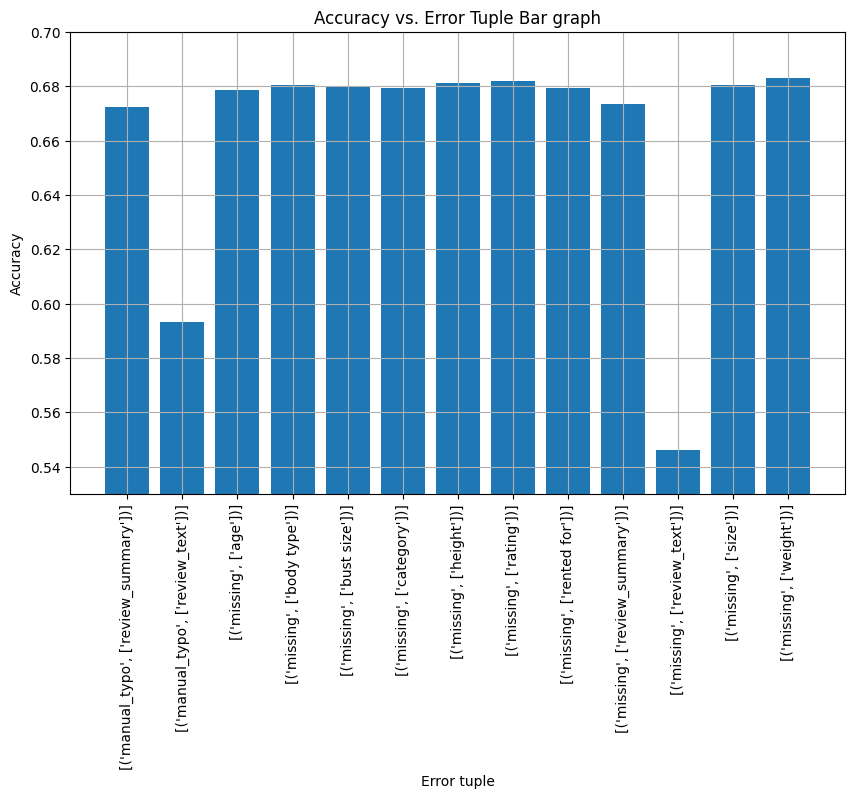

In [ ]:
import matplotlib.pyplot as plt

def plot_test_result(file):
  df = pd.read_csv(file)
  df.rename(columns={ df.columns[0]: "type" }, inplace = True)

  df = df.loc[lambda x: x["type"] == "accuracy"]
  accuracy = (df["precision"]).astype(float)
  error_tuple = df["error tuple"]
  random_state = df['random state']

  accuracy = pd.concat([error_tuple, accuracy, random_state], axis = 1)

  grouped_data =accuracy.groupby('error tuple')['precision'].mean().reset_index()

  # Plot the average accuracy against the error tuple
  plt.figure(figsize=(10, 6))
  plt.bar(grouped_data['error tuple'], grouped_data['precision'])

  print(grouped_data)


  plt.xlabel('Error tuple')
  plt.ylabel('Accuracy')
  plt.ylim(0.53, 0.70)
  plt.xticks(rotation=90)
  plt.title('Accuracy vs. Error Tuple Bar graph')
  plt.grid(True)
  plt.show()


plot_test_result(file)
